# 1. Imports

In [3]:
# 1. Imports libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import joblib

# plotting settings
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# reduce pandas warnings
pd.options.mode.chained_assignment = None


# 2. Configuration



In [4]:
DATA_PATH = "s3://mybucket-training-98765/AB_NYC_2019.csv"   
MLFLOW_TRACKING_URI = None          
EXPERIMENT_NAME = "airbnb_price_student"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ============================
# 3. Helper functions
# ============================

In [5]:
# 3. Helper functions

def load_data(path):
    """Load CSV; if not found raise helpful message."""
    if path.startswith("s3://"):
        import s3fs
        df = pd.read_csv(path, storage_options={})
    else:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Data file not found at {path}. Put your CSV at this path or update DATA_PATH.")
        df = pd.read_csv(path)
    return df

def clean_price_col(df, price_col="price"):
    """Strip $ , and convert to float"""
    if price_col not in df.columns:
        raise KeyError(f"{price_col} not found in dataframe columns.")
    df = df.copy()
    df[price_col] = df[price_col].astype(str).str.replace(r"[\$,]", "", regex=True)
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    return df

def basic_report(df, n=5):
    print("Shape:", df.shape)
    display(df.head(n))
    print("\nMissing values per column:")
    display(df.isna().sum().sort_values(ascending=False).head(20))


# ============================
# 4. Load data
# ============================


In [6]:
# 4. Load data
try:
    df = load_data(DATA_PATH)
    print("Loaded data from", DATA_PATH)
except Exception as e:
    print("Error loading data:", e)
    # For demo: create a tiny synthetic dataset if file missing
    print("Creating tiny synthetic demo dataframe...")
    np.random.seed(RANDOM_STATE)
    n = 500
    df = pd.DataFrame({
        "id": range(n),
        "latitude": 40.7 + np.random.randn(n)*0.02,
        "longitude": -73.95 + np.random.randn(n)*0.02,
        "neighbourhood_group": np.random.choice(["Brooklyn","Manhattan","Queens"], n),
        "neighbourhood": np.random.choice(["A","B","C","D"], n),
        "room_type": np.random.choice(["Entire home/apt","Private room","Shared room"], n),
        "price": np.random.randint(50, 500, n),
        "minimum_nights": np.random.randint(1, 10, n),
        "number_of_reviews": np.random.poisson(5, n),
        "reviews_per_month": np.random.rand(n)*2,
        "availability_365": np.random.randint(0, 365, n),
        "amenities": np.random.choice(["['Wifi','Kitchen']","['Wifi']","['Kitchen','Heating']","[]"], n)
    })

basic_report(df)


Loaded data from s3://mybucket-training-98765/AB_NYC_2019.csv
Shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0



Missing values per column:


last_review                       10052
reviews_per_month                 10052
host_name                            21
name                                 16
neighbourhood_group                   0
neighbourhood                         0
id                                    0
host_id                               0
longitude                             0
latitude                              0
room_type                             0
price                                 0
number_of_reviews                     0
minimum_nights                        0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# ============================
# 5 EDa
# ============================


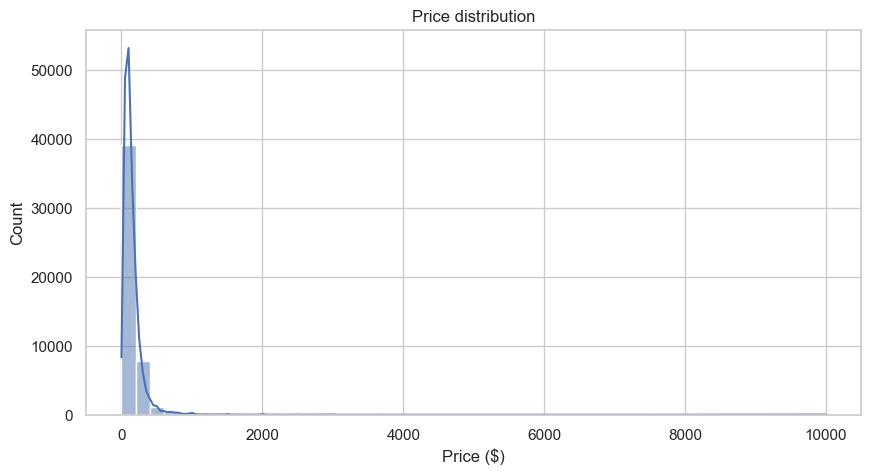

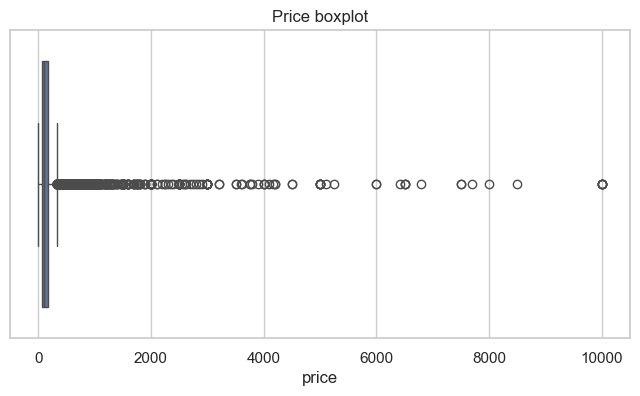

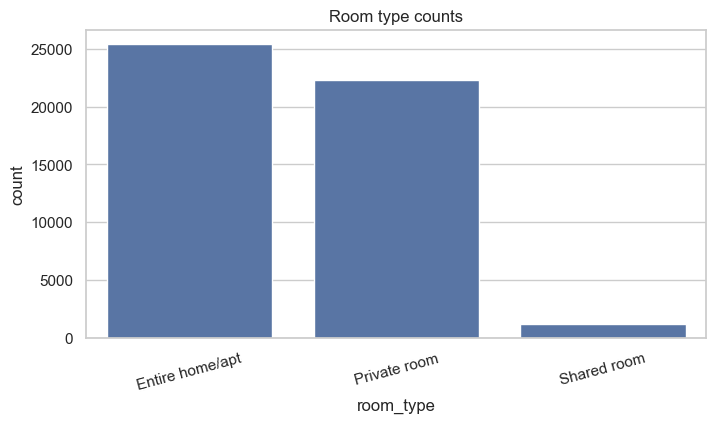

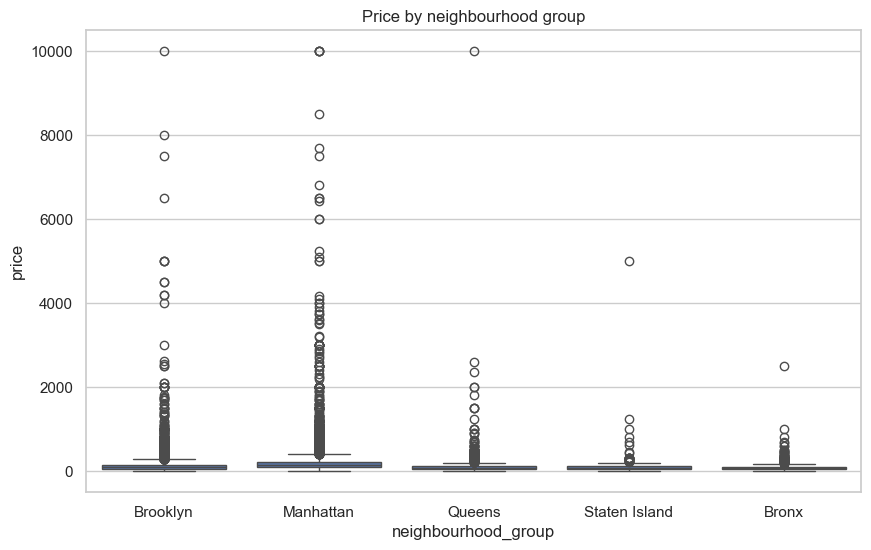

In [7]:
# 5.1 Price distribution
plt.figure(figsize=(10,5))
sns.histplot(df['price'].dropna(), bins=50, kde=True)
plt.title("Price distribution")
plt.xlabel("Price ($)")
plt.show()

# 5.2 Boxplot for price
plt.figure(figsize=(8,4))
sns.boxplot(x=df['price'])
plt.title("Price boxplot")
plt.show()

# 5.3 Room type counts
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='room_type', order=df['room_type'].value_counts().index)
plt.title("Room type counts")
plt.xticks(rotation=15)
plt.show()

# 5.4 Price by neighbourhood_group
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='neighbourhood_group', y='price')
plt.title("Price by neighbourhood group")
plt.show()


# ============================
#7 Correlation heatmap
# ============================


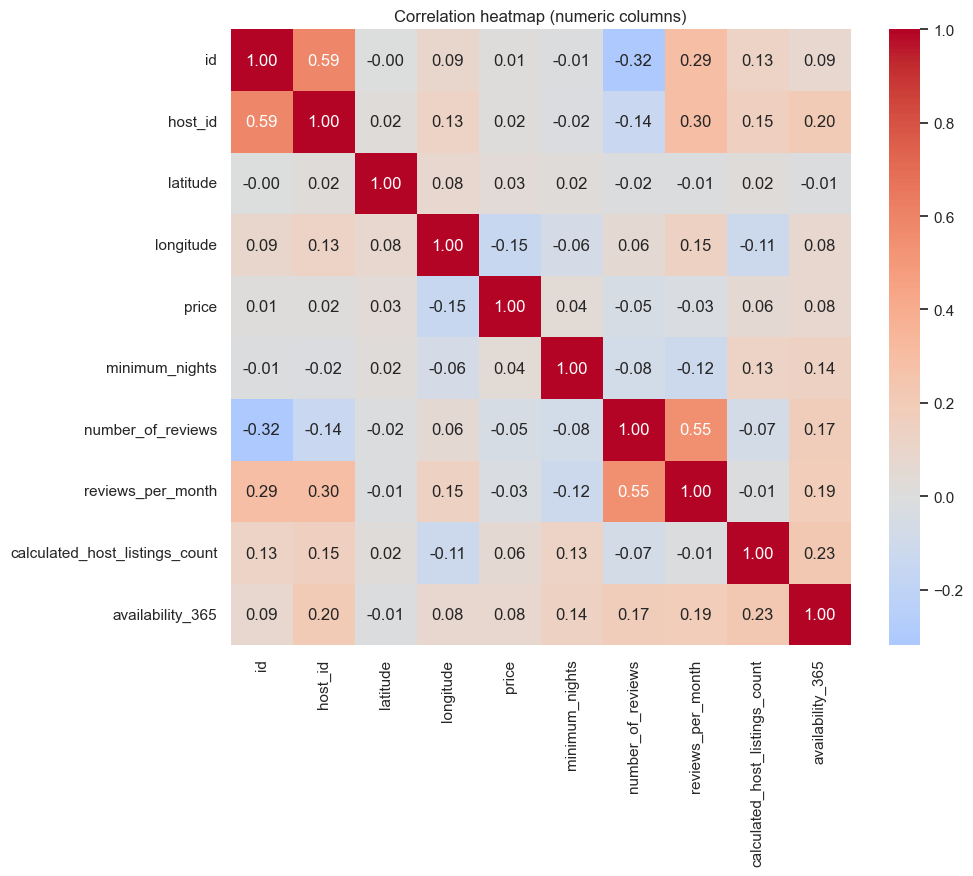

In [8]:
# numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation heatmap (numeric columns)")
plt.show()


# ============================
# 8. Data cleaning

# ============================



In [9]:
# 8. Data cleaning
df = clean_price_col(df, "price")
# Drop rows missing price
df = df.dropna(subset=["price"]).reset_index(drop=True)

# Cap extreme price outliers to 1st-99th percentile to reduce their influence
low, high = df['price'].quantile([0.01, 0.99])
print(f"Capping price to [{low:.2f}, {high:.2f}]")
df['price_capped'] = df['price'].clip(lower=low, upper=high)

# Simple missing value fill for reviews_per_month: 0 if missing
if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

basic_report(df)


Capping price to [30.00, 799.00]
Shape: (48895, 17)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_capped
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,149
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,225
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,150
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,89
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,80



Missing values per column:


last_review                       10052
host_name                            21
name                                 16
id                                    0
host_id                               0
neighbourhood                         0
latitude                              0
longitude                             0
neighbourhood_group                   0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
price_capped                          0
dtype: int64

# ============================
# 9. Feature Engineering (Fixed)
# ============================


In [ ]:

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# 1. Review Score
df["review_score"] = df["number_of_reviews"] * df["reviews_per_month"].fillna(0)

# 2categorical conversion)
df["host_activity"] = df["calculated_host_listings_count"].apply(
    lambda x: 1 if x == 1 else (2 if x <= 5 else 3)
)

# 3. Distance to city center
CENTER_LAT, CENTER_LON = 40.7128, -74.0060

def approx_distance(lat, lon, lat2=CENTER_LAT, lon2=CENTER_LON):
    # Approx degrees → km (111km per degree)
    return np.sqrt((lat - lat2)**2 + (lon - lon2)**2) * 111

df["dist_to_center_km"] = approx_distance(df["latitude"], df["longitude"])

# 4. Location Clusters using KMeans (5 clusters)
coords = df[["latitude", "longitude"]]

kmeans = KMeans(n_clusters=5, random_state=42)
df["location_cluster"] = kmeans.fit_predict(coords)

# Show correlations
display(
    df[
        [
            "price",
            "price_capped",
            "review_score",
            "dist_to_center_km",
            "host_activity",
        ]
    ].corr()
)

print("Feature engineering completed successfully!")
df.head()



,price,price_capped,review_score,dist_to_center_km,host_activity
price,1.000000,0.703851,-0.039364,-0.158280,-0.007348
price_capped,0.703851,1.000000,-0.058768,-0.278286,-0.016803
review_score,-0.039364,-0.058768,1.000000,0.078593,0.041585
dist_to_center_km,-0.158280,-0.278286,0.078593,1.000000,0.061515
host_activity,-0.007348,-0.016803,0.041585,0.061515,1.000000


Feature engineering completed successfully!


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_capped,review_score,host_activity,dist_to_center_km,location_cluster
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,9,2018-10-19,0.21,6,365,149,1.89,3,8.154061,3
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,45,2019-05-21,0.38,2,355,225,17.10,2,5.159346,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0,NaN,0.00,1,365,150,0.00,1,12.833395,2
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,270,2019-07-05,4.64,1,194,89,1252.80,1,5.980844,4
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,9,2018-11-19,0.10,1,0,80,0.90,1,11.742648,2


# ============================
# 10 Prepare feature
# ============================


In [11]:

TARGET = 'price_capped'  
features = []
for c in ['minimum_nights','number_of_reviews','reviews_per_month','availability_365','amenities_count','dist_to_center_km']:
    if c in df.columns:
        features.append(c)
# include categorical
cat_cols = [c for c in ['neighbourhood_group','room_type','neighbourhood'] if c in df.columns]

X = df[features + cat_cols].copy()
y = df[TARGET].copy()
X.shape, y.shape


((48895, 8), (48895,))

11 — Train/test split

In [12]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (39116, 8) Test shape: (9779, 8)


12 — Build preprocessing pipeline

In [13]:
# 12. Preprocessing pipeline
numeric_features = [c for c in features if c in X.columns]
categorical_features = [c for c in cat_cols if c in X.columns]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

13 — Train Linear Regression

In [14]:
# 13. Train linear regression
lr_pipeline = Pipeline([('preproc', preprocessor), ('model', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

def evaluate(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "r2": r2}

lr_metrics = evaluate(y_test, lr_preds)
print("Linear Regression metrics:", lr_metrics)


Linear Regression metrics: {'rmse': 9070.24311706831, 'mae': 55.97603740249967, 'r2': 0.36139691849186883}


14 — Train Random Forest

In [15]:
# 14. Train RandomForest (simple settings)
rf_pipeline = Pipeline([('preproc', preprocessor), ('model', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
rf_metrics = evaluate(y_test, rf_preds)
print("Random Forest metrics:", rf_metrics)


Random Forest metrics: {'rmse': 8373.883718609606, 'mae': 52.43702866687119, 'r2': 0.4104250704336895}


15 — Visual evaluation plots

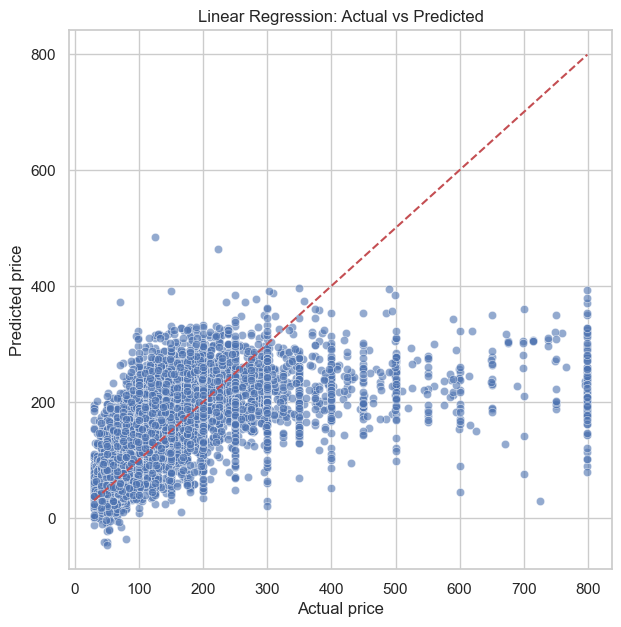

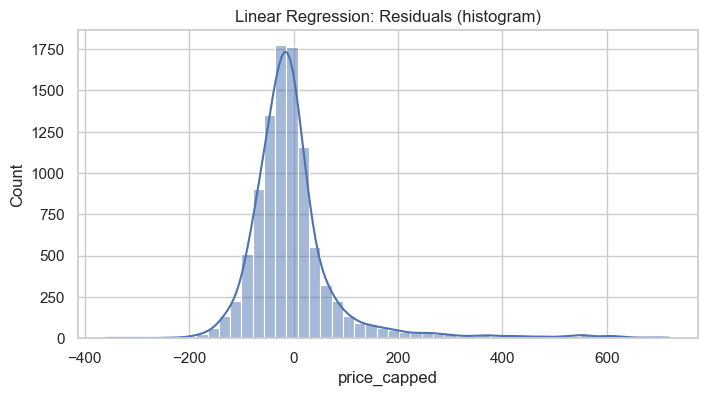

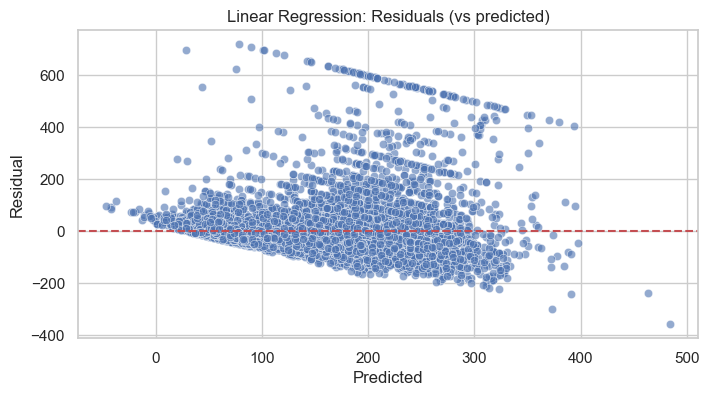

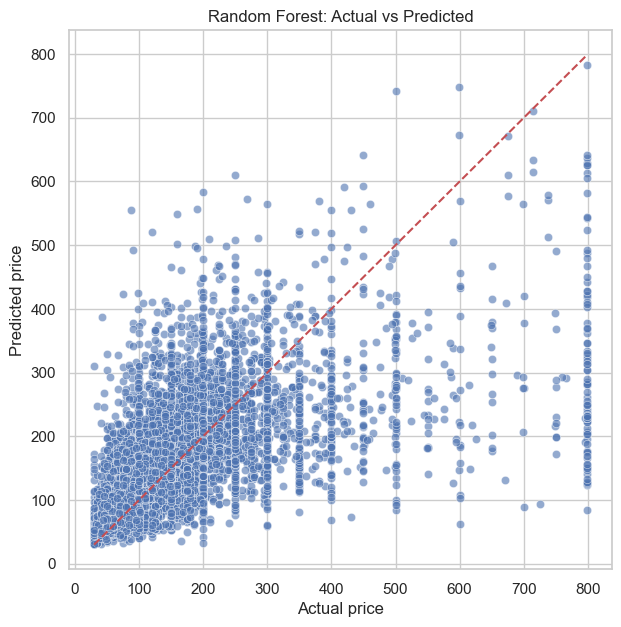

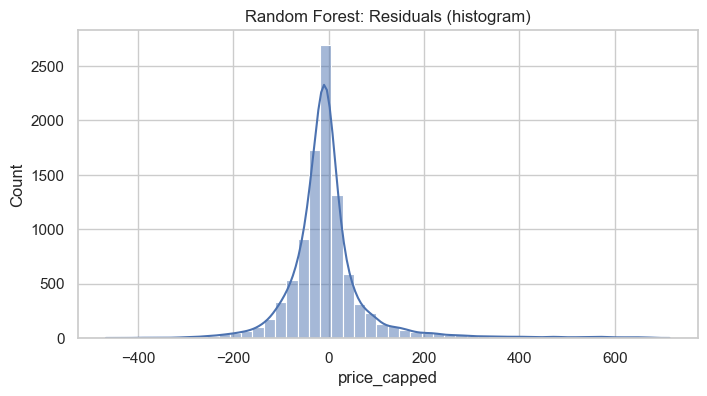

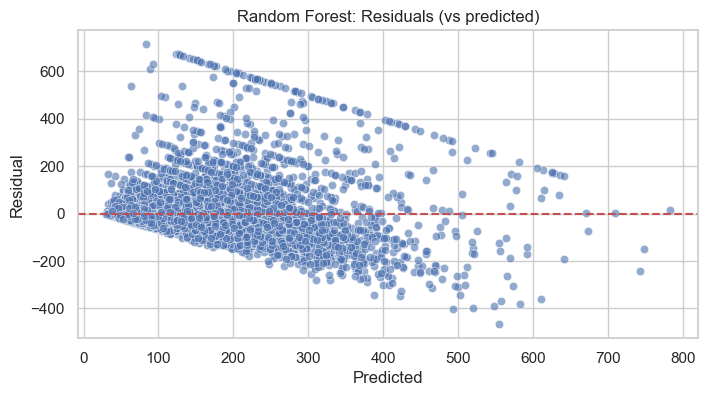

In [16]:
# 15. Visual evaluation
def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price")
    plt.title(title)
    plt.show()

def plot_residuals(y_true, y_pred, title="Residuals"):
    res = y_true - y_pred
    plt.figure(figsize=(8,4))
    sns.histplot(res, bins=50, kde=True)
    plt.title(title + " (histogram)")
    plt.show()
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=y_pred, y=res, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.title(title + " (vs predicted)")
    plt.show()

# LR plots
plot_actual_vs_pred(y_test, lr_preds, "Linear Regression: Actual vs Predicted")
plot_residuals(y_test, lr_preds, "Linear Regression: Residuals")

# RF plots
plot_actual_vs_pred(y_test, rf_preds, "Random Forest: Actual vs Predicted")
plot_residuals(y_test, rf_preds, "Random Forest: Residuals")


16 — Feature importance for Random Forest

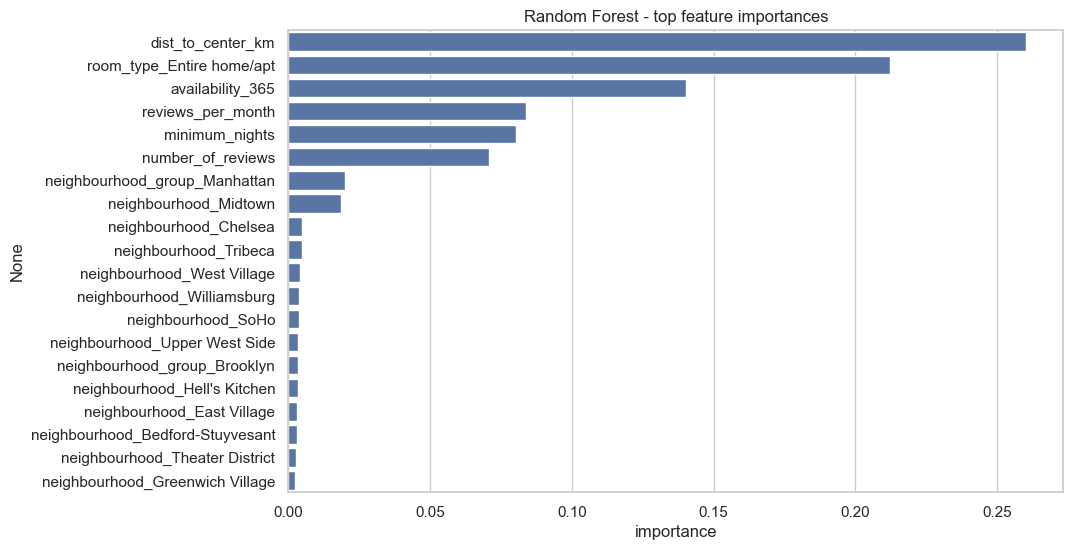

In [17]:
# Get numeric feature names
num_names = numeric_features
# get onehot names
onehot = rf_pipeline.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot'] if 'cat' in rf_pipeline.named_steps['preproc'].named_transformers_ else None
cat_ohe_names = []
if onehot is not None:
    cat_feature_names = onehot.get_feature_names_out(categorical_features)
    cat_ohe_names = list(cat_feature_names)

all_feature_names = num_names + cat_ohe_names

# from the RandomForest model
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title("Random Forest - top feature importances")
plt.xlabel("importance")
plt.show()


17 — Simple MLflow logging

In [18]:
# 17. Simple MLflow logging
if MLFLOW_TRACKING_URI:
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name="rf_vs_lr_student"):
    # log parameters
    mlflow.log_param("model_lr", "LinearRegression")
    mlflow.log_param("model_rf", "RandomForest(100)")
    mlflow.log_param("features", ",".join(features + categorical_features))
    # log metrics for LR
    for k,v in lr_metrics.items():
        mlflow.log_metric(f"lr_{k}", v)
    # log metrics for RF
    for k,v in rf_metrics.items():
        mlflow.log_metric(f"rf_{k}", v)
    # log model
    mlflow.sklearn.log_model(rf_pipeline, "random_forest_pipeline")
    # save pipeline locally too
    joblib.dump(rf_pipeline, "rf_pipeline_student.joblib")
    mlflow.log_artifact("rf_pipeline_student.joblib")
    print("Logged run to MLflow with id:", mlflow.active_run().info.run_id)


c:\Users\kaurd\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/21 16:01:14 INFO mlflow.tracking.fluent: Experiment with name 'airbnb_price_student' does not exist. Creating a new experiment.
2025/11/21 16:01:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/21 16:01:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged run to MLflow with id: 5fc4933cd2e04c8faad536e1399ff301


Save important results to disk

In [19]:
# Save results
results = {
    "lr": lr_metrics,
    "rf": rf_metrics,
    "rf_pipeline_path": "rf_pipeline_student.joblib"
}
pd.Series({f"lr_{k}": v for k,v in lr_metrics.items()}).to_csv("lr_metrics.csv")
pd.Series({f"rf_{k}": v for k,v in rf_metrics.items()}).to_csv("rf_metrics.csv")
import json
with open("results_summary.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved metrics files and model pipeline.")


Saved metrics files and model pipeline.
